# Suppressing artificial reflections with absorber and PML boundaries

In an FDTD simulation, Maxwell's equations are discretized on a finite grid. Simply truncating the computational domain at a boundary can cause outgoing electromagnetic waves to reflect back, contaminating the solution. To prevent these artificial reflections, absorbing boundary conditions are introduced. These boundaries are artificial regions placed at the edge of the computational domain to simulate "open" or unbounded space. Their purpose is to absorb outgoing waves as if the domain extended to infinity, while minimizing reflections back into the interior. Tidy3D offers two primary types of absorbing boundaries: **perfectly matched layers (PML)** and **adiabatic absorbers**.

PML uses a mathematically derived "coordinate stretching" or anisotropic material approach to achieve a perfect impedance match at the boundary. By design, PML ideally causes zero reflection at the interface and then exponentially attenuates the wave within the absorbing layer. In contrast, an adiabatic absorber employs a smooth spatial transition in material parameters (e.g., conductivity, permittivity) from the physical domain into an absorbing medium. It aims to minimize, rather than strictly eliminate, reflections by gradually grading the absorption profile so the wave encounters no abrupt transitions.

Although PML is more effective at eliminating artificial reflections, it can lead to simulation stability issues, particularly when the structure in the PML is not translationally invariant, the medium is dispersive, or when structures are too close to PML such that evanescent fields leak into it. The adiabatic absorber, on the other hand, is very similar to a physical absorbing region that is purely passive and always stable. Therefore, the choice of absorbing boundary condition depends on the specific simulation setup. If a simulation is diverging with PML, switching to the adiabatic absorber can often resolve the issue. This [waveguide to ring coupling example](https://www.flexcompute.com/tidy3d/examples/notebooks/WaveguideToRingCoupling/) is a canonical example.

Many users are concerned that the higher artificial reflections from the adiabatic absorber can result in inaccurate simulation results. However, using a larger number of layers to create a more gradual ramp-up of absorption can effectively mitigate this, albeit at a higher computational cost due to the increased number of FDTD cells required. Thus, achieving the right balance between accuracy and computational cost is crucial. This notebook aims to benchmark the undesired reflections from absorbing boundaries and guide users in selecting the most appropriate settings for their simulations and objectives.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web

## Simulation Setup

In this benchmark, we will focus on the telecommunications wavelength and examine the reflection of a basic waveguide mode at the boundary.

In [2]:
lda0 = 1.55  # Central wavelength
freq0 = td.C_0 / lda0  # Calculate the frequency corresponding to the central wavelength

# Create an array of 21 evenly spaced wavelengths between 1.5 and 1.6
ldas = np.linspace(1.5, 1.6, 21)

# Calculate the frequencies corresponding to each wavelength in the ldas array
freqs = td.C_0 / ldas

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # Calculate the source frequency width

We use a standard single-mode silicon waveguide with a width of 500 nm and a thickness of 220 nm.

In [3]:
w_wg = 0.5  # Width of the waveguide
t_wg = 0.22  # Thickness of the waveguide

Define silicon and oxide as simple nondispersive media.

In [4]:
n_oxide = 1.44  # Refractive index of oxide

oxide = td.Medium(permittivity=n_oxide**2)

n_si = 3.47  # Refractive index of silicon
si = td.Medium(permittivity=n_si**2)

Create a basic waveguide structure.

In [5]:
waveguide = td.Structure(geometry=td.Box(size=[td.inf, w_wg, t_wg]), medium=si)

Next, we define the size of the simulation domain. For this benchmark, the domain can be relatively small.

Afterward, we create a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to excite the fundamental mode in the waveguide. To measure the reflection from the boundary, we set up a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html).

In [6]:
l_x = 3 * lda0  # Calculate the simulation domain size in the x-direction
l_y = w_wg + 2 * lda0  # Calculate the simulation domain size in the y-direction
l_z = t_wg + 2 * lda0  # Calculate the simulation domain size in the z-direction

buffer = lda0 / 2  # Define a buffer spacing

# Create a mode source for excitation
modesource = td.ModeSource(
    center=[-l_x / 2 + buffer, 0, 0],
    size=[0, 3 * w_wg, 5 * t_wg],
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
)

# Create a mode monitor to measure reflection at the boundary
modemonitor = td.ModeMonitor(
    name="modemonitor",
    center=[l_x / 2 - buffer, 0, 0],
    size=modesource.size,
    freqs=freqs,
    mode_spec=modesource.mode_spec,
)

## Adiabatic Absorber

We start by defining a function called `make_sim`, which is intended to create a simulation based on three parameters: `num_layers`,  `use_absorber`, and `grid_resolution`. The `num_layers` parameter specifies the number of absorbing boundary layers in the simulation, while the `use_absorber` parameter is a boolean that determines whether to use adiabatic absorbers or PML. `grid_resolution` specifies the number of grid points per material wavelength.

This function will facilitate a parameter sweep to quantitatively analyze reflection as it relates to the number of boundary layers and grid resolution. In general, using a larger number of layers allows for more gradual absorption and less reflection. For an adiabatic absorber, the reflection also depends on the grid resolution since it affects the layer thickness. For simulations with a finer grid resolution, usually a larger number of absorbers is needed.

In [7]:
def make_sim(num_layers, use_absorber=True, grid_resolution=25):
    # Create a simulation object using the tidy3d library
    # Parameters:
    # num_layers: Number of layers for the absorbing boundary
    # use_absorber: Boolean to determine if absorbing or PML boundaries are used in the x direction
    # grid_resolution: Minimum number of grid points per material wavelength

    sim = td.Simulation(
        size=[l_x, l_y, l_z],
        symmetry=[0, -1, 1],
        # Define boundary specifications based on whether absorption is enabled
        boundary_spec=(
            td.BoundarySpec(
                x=td.Boundary.absorber(
                    num_layers
                ),  # Use adiabatic absorber boundary with the specific number of layers in the x direction if use_absorber is True
                y=td.Boundary.pml(),
                z=td.Boundary.pml(),
            )
            if use_absorber
            else td.BoundarySpec(
                x=td.Boundary.pml(
                    num_layers
                ),  # Use PML with the specified number of layers in the x direction if use_absorber is False
                y=td.Boundary.pml(),
                z=td.Boundary.pml(),
            )
        ),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=grid_resolution, wavelength=lda0),
        run_time=1e-12,
        medium=oxide,
        sources=[modesource],
        monitors=[modemonitor],
        structures=[waveguide],
    )

    return sim

Create a sample simulation and visualize the setup.

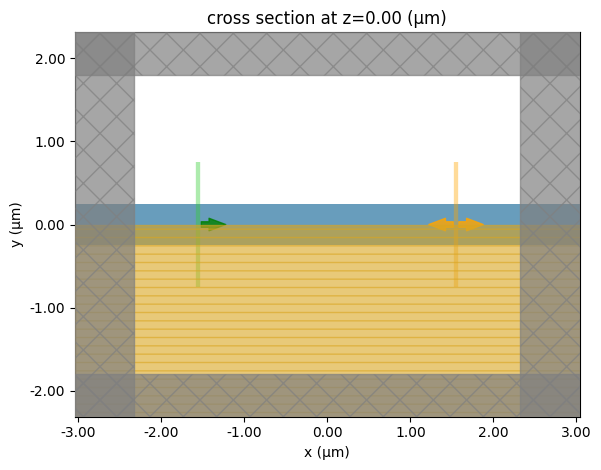

In [8]:
# Create a simulation object with 40 layers of absorber
sim = make_sim(num_layers=40)

# Plot the simulation results at z=0 to visualize the simulation
sim.plot(z=0)
plt.show()

### Reflection as a Function of Number of Layers

By default, the adiabatic absorber contains 40 layers. Here, we keep the grid resolution the same and generate a list of absorber layer counts ranging from 10 to 100, with increments of 10. This list will enable us to explore how varying numbers of absorber layers influence reflection. Simultaneously, we will monitor the number of FDTD cells for each simulation, as this could directly affect both the FlexCredit cost and the simulation time.

To conduct the parameter sweep, we will create a dictionary of simulations and then use a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) to execute them.

In [9]:
num_layers_list = list(
    range(10, 101, 10)
)  # Create a list of absorber layer counts from 10 to 100 in increments of 10
num_cells_list = []  # Initialize an empty list to store the number of cells for each simulation

# Initialize an empty dictionary to store simulation objects with their respective layer counts as keys
sims = {}

# Loop over each number of absorber layers to create simulations
for num_layers in num_layers_list:
    sim = make_sim(num_layers)
    # Append the number of cells (converted to millions) to the num_cells_list
    num_cells_list.append(sim.num_cells / 1e6)
    sims[f"{num_layers} layers"] = sim

# Create a batch of simulations
batch = web.Batch(simulations=sims, verbose=True)

# Run the batch of simulations and save results to the specified directory
batch_results = batch.run(path_dir="data")

Output()

12:10:11 Eastern Standard Time Started working on Batch containing 10 tasks.

12:10:18 Eastern Standard Time Maximum FlexCredit cost: 0.251 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

12:10:22 Eastern Standard Time Batch complete.

Output()

After completing the simulations, we can extract and plot the reflection spectrum. The results clearly show that increasing the number of adiabatic absorber layers reduces the reflection. Notably, the default setting of **40 layers** results in a reflection of **-25 dB**, while increasing to **80 layers** reduces the reflection to approximately **-60 dB**.

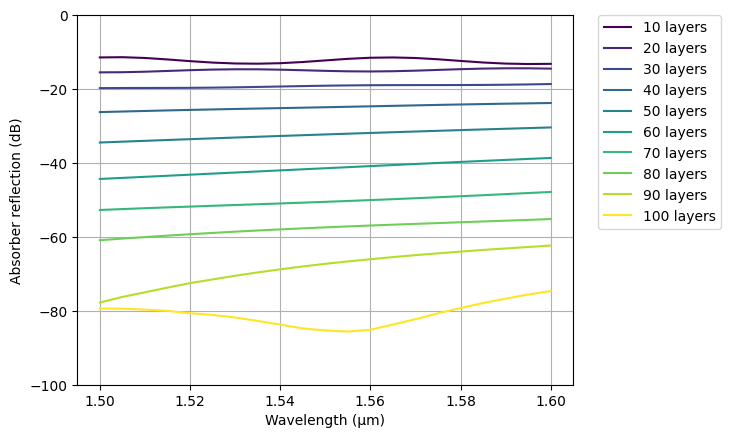

In [10]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Normalize the colormap based on the minimum and maximum values in the num_layers_list
norm = mcolors.Normalize(vmin=min(num_layers_list), vmax=max(num_layers_list))
colormap = cm.viridis  # Use the 'viridis' colormap for plotting

# Iterate over each number of absorber layers in the list
for num_layers in num_layers_list:

    # Calculate the reflection values by taking the absolute square of the mode amplitude values from the simulation results
    reflection = (
        np.abs(batch_results[f"{num_layers} layers"]["modemonitor"].amps.sel(direction="-").values)
        ** 2
    )
    # Get the color corresponding to the current number of layers using the normalized colormap
    color = colormap(norm(num_layers))
    # Plot the reflection values in dB against the wavelengths, using the specified color and label
    plt.plot(ldas, 10 * np.log10(reflection), color=color, label=f"{num_layers} layers")


plt.ylim(-100, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Absorber reflection (dB)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
plt.grid()
plt.show()

As discussed, increasing the number of layers can help reduce unwanted reflections, but it may also significantly raise the cost. In the accompanying plot, we show the reflection at the central wavelength (1550 nm) alongside the number of FDTD cells. In very small simulations, such as this benchmark model, using more absorber layers might not increase the cost since all simulations remain below the minimal cost threshold. However, for larger simulations, the cost difference between using 100 layers and 40 layers can be substantial. Users must balance accuracy and cost based on their objectives and tolerance levels.

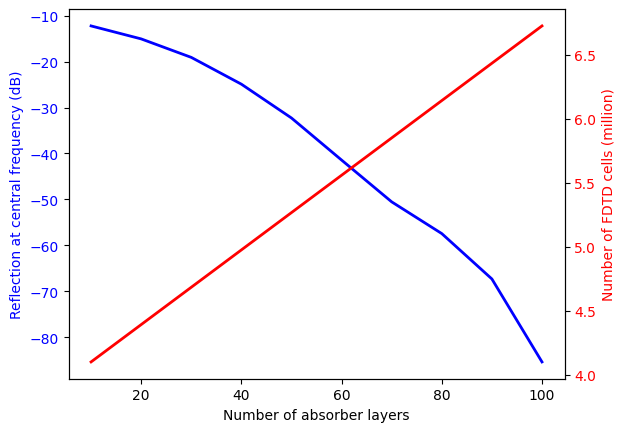

In [11]:
# Calculate the reflection values at the central frequency for different numbers of absorber layers
reflection_freq0 = [
    np.abs(
        batch_results[f"{num_layers} layers"]["modemonitor"].amps.sel(direction="-", f=freq0).values
    )
    ** 2
    for num_layers in num_layers_list
]


fig, ax1 = plt.subplots()

# Plot the reflection values in dB against the number of absorber layers
ax1.plot(num_layers_list, 10 * np.log10(reflection_freq0), color="b", linewidth=2)
ax1.set_xlabel("Number of absorber layers")
ax1.set_ylabel("Reflection at central frequency (dB)", color="b")
ax1.tick_params(axis="y", labelcolor="b")

# Create a second y-axis sharing the same x-axis for additional data visualization
ax2 = ax1.twinx()
# Plot the number of FDTD cells (in millions) against the number of absorber layers
ax2.plot(num_layers_list, num_cells_list, color="r", linewidth=2)
ax2.set_ylabel("Number of FDTD cells (million)", color="r")
ax2.tick_params(axis="y", labelcolor="r")

plt.show()

### Reflection as a Function of Grid Resolution

Next we are going to test how the reflection depends on the grid resolution and thus the physical layer thickness of the absorber region. Simiarly we perform a parameter sweep from 10 to 30 minimum steps per wavelength. 

In [12]:
grid_resolution_list = list(
    range(10, 31, 5)
)  # Create a list of absorber layer counts from 10 to 100 in increments of 10

# Initialize an empty dictionary to store simulation objects with their respective layer counts as keys
sims = {}

# Loop over each number of absorber layers to create simulations
for grid_resolution in grid_resolution_list:
    sim = make_sim(num_layers=60, grid_resolution=grid_resolution)
    # Append the number of cells (converted to millions) to the num_cells_list
    sims[f"{grid_resolution} steps per wavelength"] = sim

# Create a batch of simulations
batch = web.Batch(simulations=sims, verbose=True)

# Run the batch of simulations and save results to the specified directory
batch_results = batch.run(path_dir="data")

Output()

12:10:31 Eastern Standard Time Started working on Batch containing 5 tasks.

12:10:34 Eastern Standard Time Maximum FlexCredit cost: 0.133 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

12:10:37 Eastern Standard Time Batch complete.

Output()

Plotting the results in a similar way, we can clearly see that the reflection increases with grid resolution since, for the same number of layers, the physical thickness of the absorber region decreases with resolution. Therefore, for simulations with a very fine grid, a larger number of absorber layers is needed. 

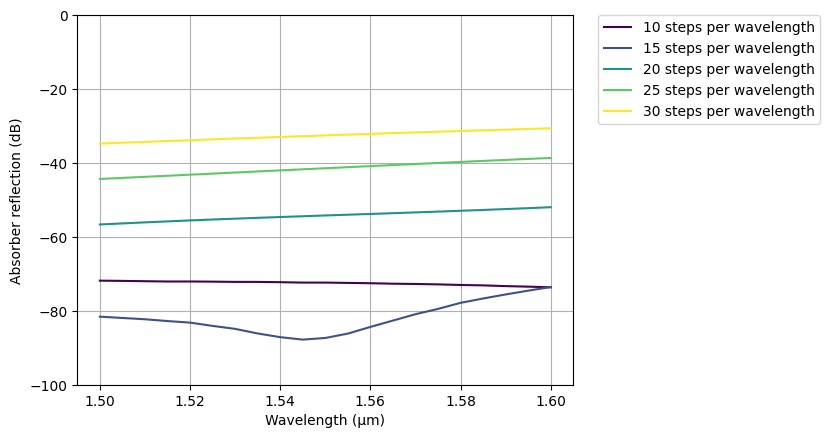

In [13]:
# Normalize the colormap based on the minimum and maximum values in the grid_resolution_list
norm = mcolors.Normalize(vmin=min(grid_resolution_list), vmax=max(grid_resolution_list))
colormap = cm.viridis  # Use the 'viridis' colormap for plotting

# Iterate over each grid_resolution in the list
for grid_resolution in grid_resolution_list:

    # Calculate the reflection values by taking the absolute square of the mode amplitude values from the simulation results
    reflection = (
        np.abs(
            batch_results[f"{grid_resolution} steps per wavelength"]["modemonitor"]
            .amps.sel(direction="-")
            .values
        )
        ** 2
    )
    # Get the color corresponding to the current grid_resolution using the normalized colormap
    color = colormap(norm(grid_resolution))
    # Plot the reflection values in dB against the wavelengths, using the specified color and label
    plt.plot(
        ldas,
        10 * np.log10(reflection),
        color=color,
        label=f"{grid_resolution} steps per wavelength",
    )


plt.ylim(-100, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("Absorber reflection (dB)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
plt.grid()
plt.show()

## PML

For comparison, we conducted the same simulation using the PML boundary condition. In Tidy3D, the default number of PML layers is 12, which typically performs very well. Increasing the number of layers generally does not provide additional benefits. In our study, we varied the number of PML layers from 10 to 20, increasing in increments of 2.

In [14]:
# Create a list of even numbers from 10 to 20, representing the number of PML layers for simulations
num_layers_list = list(range(10, 21, 2))


sims = {
    f"{num_layers} layers": make_sim(num_layers, use_absorber=False)
    for num_layers in num_layers_list
}


batch = web.Batch(simulations=sims, verbose=True)

batch_results = batch.run(path_dir="data")

Output()

12:10:50 Eastern Standard Time Started working on Batch containing 6 tasks.

12:10:54 Eastern Standard Time Maximum FlexCredit cost: 0.150 for the whole     
                               batch.

                               Use 'Batch.real_cost()' to get the billed        
                               FlexCredit cost after the Batch has completed.

Output()

12:10:56 Eastern Standard Time Batch complete.

Output()

The plot clearly demonstrates that PML with 12 layers outperforms the adiabatic absorber with 100 layers, highlighting the superiority of PML. The reflection is already at the level of numerical noise, so users can typically rely on the default settings.

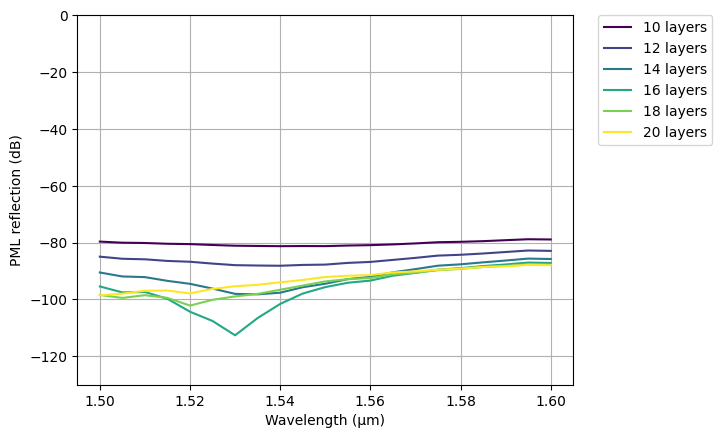

In [15]:
norm = mcolors.Normalize(vmin=min(num_layers_list), vmax=max(num_layers_list))
colormap = cm.viridis  # Use the 'viridis' colormap for plotting

for num_layers in num_layers_list:

    reflection = (
        np.abs(batch_results[f"{num_layers} layers"]["modemonitor"].amps.sel(direction="-").values)
        ** 2
    )
    color = colormap(norm(num_layers))
    plt.plot(ldas, 10 * np.log10(reflection), color=color, label=f"{num_layers} layers")

plt.ylim(-130, 0)
plt.xlabel("Wavelength (μm)")
plt.ylabel("PML reflection (dB)")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.0)
plt.grid()
plt.show()

For PML, the reflection shouldn't depend noticably on the grid resolution so we can skip the corresponding test here.

## Final Remarks

This notebook illustrates the differences in reflection between adiabatic absorbers and PML, emphasizing how the number of layers influences performance. Reflection from the absorber can arise from two main sources. The first, and more common, issue is that the conductivity does not increase gradually enough. This can be addressed by increasing the number of absorber layers, which is set to 40 by default. The second issue occurs when the absorption is insufficient, allowing light to reach the Perfect Electric Conductor (PEC) boundary at the end of the absorber and reflect back without being fully attenuated before re-entering the simulation region. This would manifest itself as the reflection level not decreasing when more layers are added. In such cases, increasing the maximum conductivity (refer to the [API documentation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AbsorberParams.html)) can be beneficial. In some cases, it could be possible to decrease `sigma_max` instead of increasing `num_layers`, if the absorption stays strong enough while becoming more gradual due to the lower maximum value. Additionally, altering the conductivity scaling order (`sigma_order`) might have an impact, though this is an advanced setting that we typically do not recommend adjusting. 

In summary, PML is highly preferred as the boundary condition when the simulation does not diverge. When absorber boundaries need to be used, users are encouraged to experiment and benchmark the reflection for the particular simulation setting they are interested in by following a similar procedure outlined in this notebook to achieve a balance between accuracy and cost. 